In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

In [2]:
project_data = pd.read_csv('results.csv')
project_data['AA_0'] = pd.to_numeric(project_data['AA_0'], errors='coerce')
project_data = project_data[["timestamp", "AA_0"]]
project_data.head()
# known_anomalies.head()


,timestamp,AA_0
0,2023-01-30 10:09:00,499.351958
1,2023-01-30 10:10:00,506.077377
2,2023-01-30 10:11:00,493.641609
3,2023-01-30 10:12:00,490.433220
4,2023-01-30 10:13:00,501.908598


In [3]:
from datetime import datetime

# Две строки с датами
date1_str = project_data['timestamp'][0]
for i in range(project_data.shape[0]):
    date2_str = project_data['timestamp'].iloc[i]

    # Преобразование строк в datetime объекты
    date1 = datetime.strptime(date1_str, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(date2_str, "%Y-%m-%d %H:%M:%S")

    # Перевод в UNIX-время (в секундах с 1 января 1970 года)
    timestamp1 = int(date1.timestamp())
    timestamp2 = int(date2.timestamp())

    # Разница во времени в секундах
    difference_in_seconds = timestamp2 - timestamp1
    project_data['timestamp'][i] = difference_in_seconds

# df['timestamp'].head()
# Вывод результата
print(f"Timestamp 1: {timestamp1} секунд {date1_str}")
print(f"Timestamp 2: {timestamp2} секунд{date2_str}")
print(f"Разница: {difference_in_seconds} секунд")


/tmp/ipykernel_1528681/64004259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['timestamp'][i] = difference_in_seconds


Timestamp 1: 1675062540 секунд 2023-01-30 10:09:00
Timestamp 2: 1686826200 секунд2023-06-15 13:50:00
Разница: 11763660 секунд


In [4]:
a = project_data['timestamp'].tolist()
b = project_data['AA_0'].tolist()
a
data = {'timestamp': a, 'value': b}
df = pd.DataFrame(data)

In [5]:
# data = {'start': [8550000, 11700000], 'end': [8654940, 11763660]}
# known_anomalies = pd.DataFrame(data)
# known_anomalies

In [6]:
# plot(dfknown_anomalies, )

In [7]:
from orion import Orion


orion = Orion(
    pipeline='tadgan.json'
)

anomalies = orion.fit_detect(df)

2024-12-12 14:24:08.919557: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 14:24:08.937243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 14:24:08.937269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 14:24:08.937284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 14:24:08.941220: I tensorflow/core/platform/cpu_feature_g

Epoch: 1/100, Losses: {'cx_loss': 7.3259, 'cz_loss': 2.1613, 'eg_loss': 7.8321}
Epoch: 2/100, Losses: {'cx_loss': 1.4516, 'cz_loss': 2.2135, 'eg_loss': 6.6839}
Epoch: 3/100, Losses: {'cx_loss': -5.3954, 'cz_loss': 2.4362, 'eg_loss': 5.2527}
Epoch: 4/100, Losses: {'cx_loss': -6.1907, 'cz_loss': 3.2087, 'eg_loss': 3.8544}
Epoch: 5/100, Losses: {'cx_loss': -7.1916, 'cz_loss': 4.1085, 'eg_loss': 1.9222}
Epoch: 6/100, Losses: {'cx_loss': -8.0542, 'cz_loss': 4.9537, 'eg_loss': -1.1679}
Epoch: 7/100, Losses: {'cx_loss': -8.6281, 'cz_loss': 5.5873, 'eg_loss': -3.299}
Epoch: 8/100, Losses: {'cx_loss': -8.7672, 'cz_loss': 6.2027, 'eg_loss': -2.9848}
Epoch: 9/100, Losses: {'cx_loss': -8.9465, 'cz_loss': 6.6025, 'eg_loss': -4.6375}
Epoch: 10/100, Losses: {'cx_loss': -8.6561, 'cz_loss': 7.4198, 'eg_loss': -5.6959}
Epoch: 11/100, Losses: {'cx_loss': -8.8712, 'cz_loss': 8.0395, 'eg_loss': -7.7003}
Epoch: 12/100, Losses: {'cx_loss': -8.7864, 'cz_loss': 7.371, 'eg_loss': -6.4019}
Epoch: 13/100, Losses:

/home/kazak/hackaton/TADGAN/anomaly-detect/utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


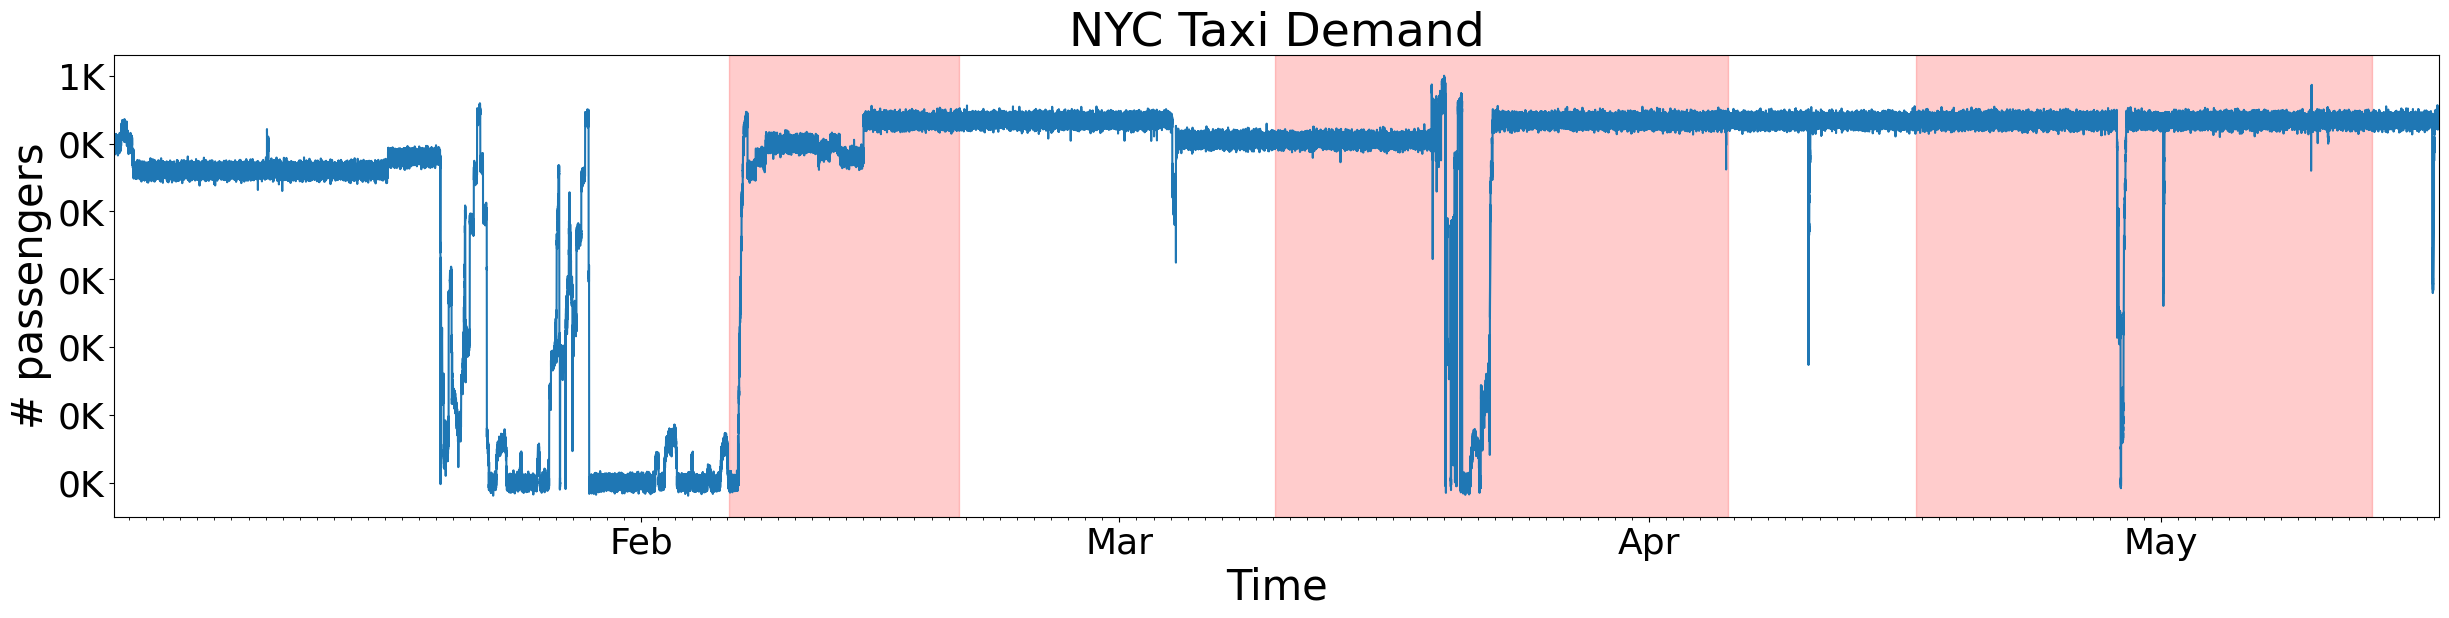

,start,end,severity
0,3110400,4276800,0.260774
1,5875200,8164800,0.071405
2,9115200,11426400,0.034075


In [8]:
# plot(df, [anomalies, known_anomalies])
plot(df, [anomalies])
anomalies.head(5)

In [9]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=60, time_column='timestamp')


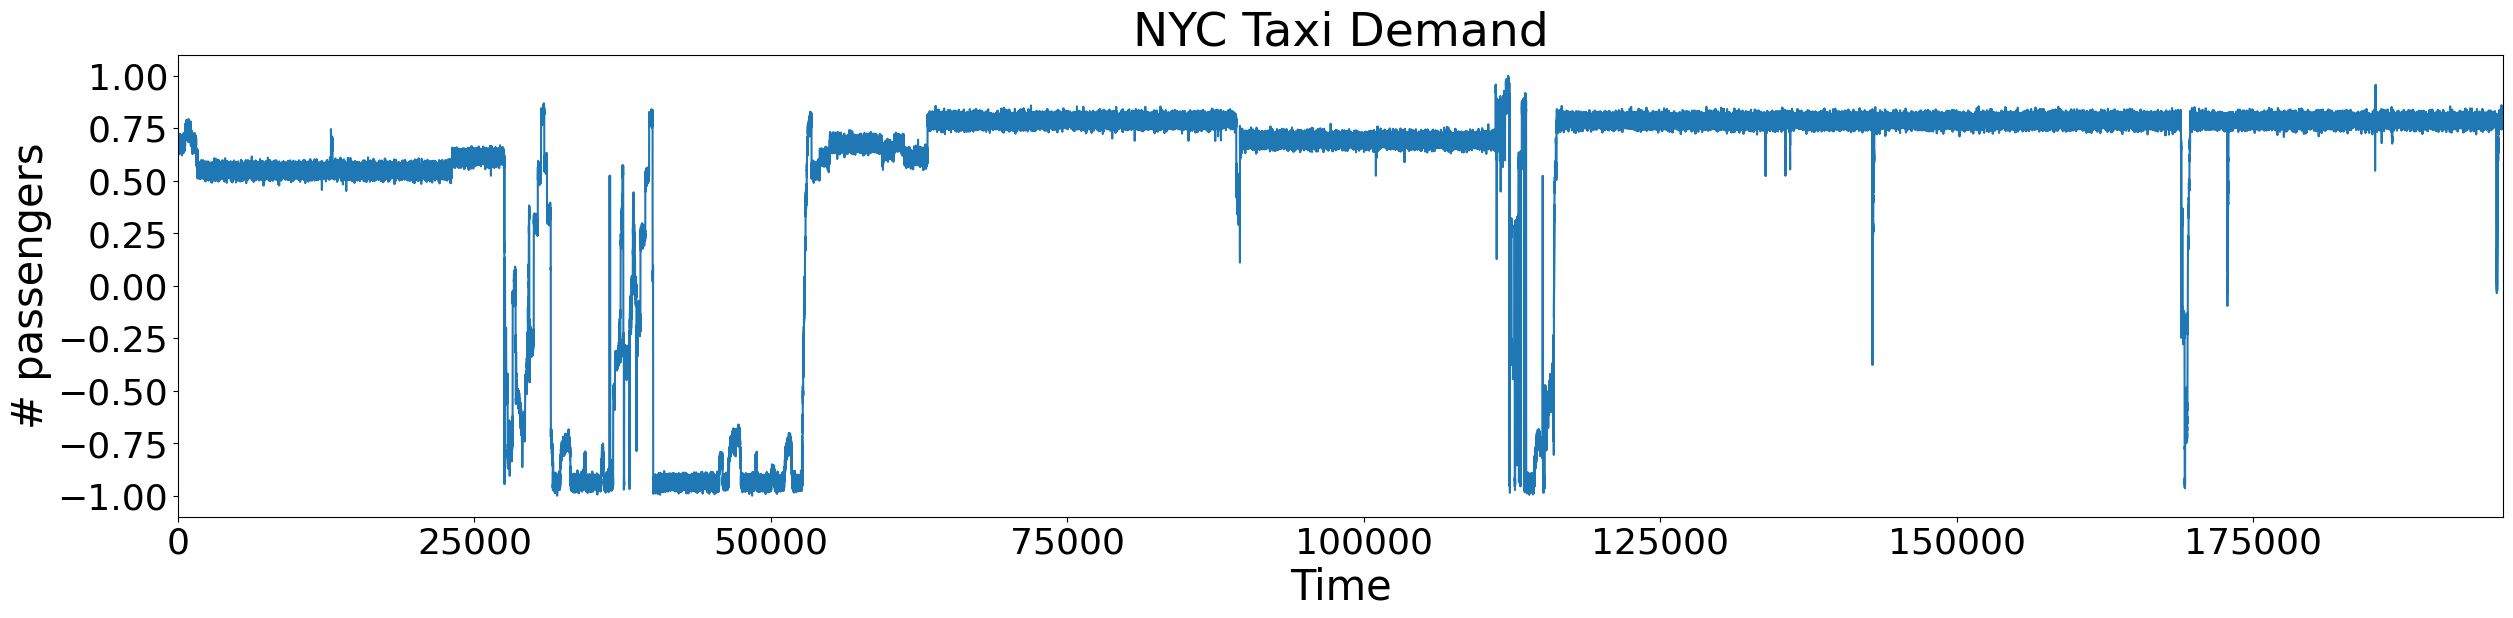

In [10]:
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
plot_ts(X)



In [11]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)


Training data input shape: (195962, 100, 1)
Training data index shape: (195962,)
Training y shape: (195962, 1)
Training y index shape: (195962,)


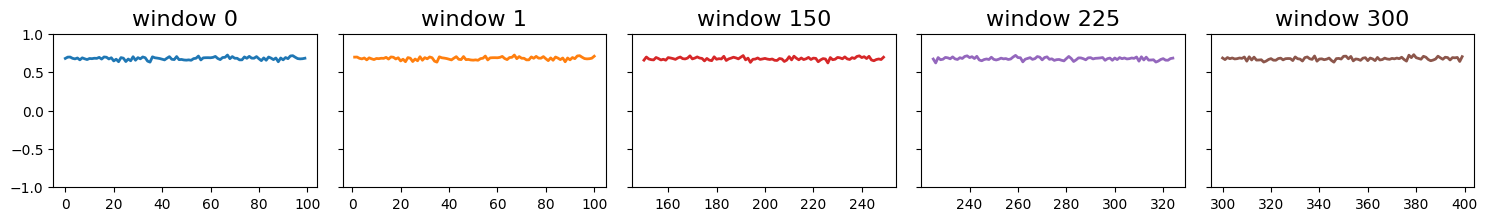

In [12]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))
plot_rws(X)


In [13]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [14]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 3
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "tensorflow.keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

2024-12-12 14:26:26.122431: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion', 16 bytes spill stores, 16 bytes spill loads



Epoch: 1/3, Losses: {'cx_loss': -0.9191, 'cz_loss': -4.0281, 'eg_loss': -2.2717}
Epoch: 2/3, Losses: {'cx_loss': -0.4567, 'cz_loss': -4.3188, 'eg_loss': -25.8397}
Epoch: 3/3, Losses: {'cx_loss': -0.4167, 'cz_loss': -4.3174, 'eg_loss': -33.2105}


6124/6124 [==============================] - 11s 2ms/step


2024-12-12 14:52:15.246611: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 26
in_depths: 64
out_depths: 64
in: 1
in: 92
data_format: 1
filter: 1
filter: 5
filter: 64
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_DOUBLE
group_count: 1
device_identifier: "sm_8.6 with 8225030144B RAM, 38 cores, 1785000KHz clock, 7001000KHz mem clock, 3145728B L2$"
version: 3



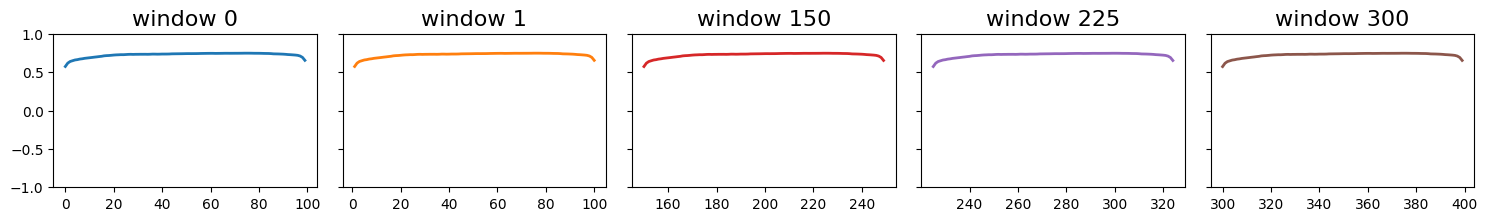

In [15]:
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)


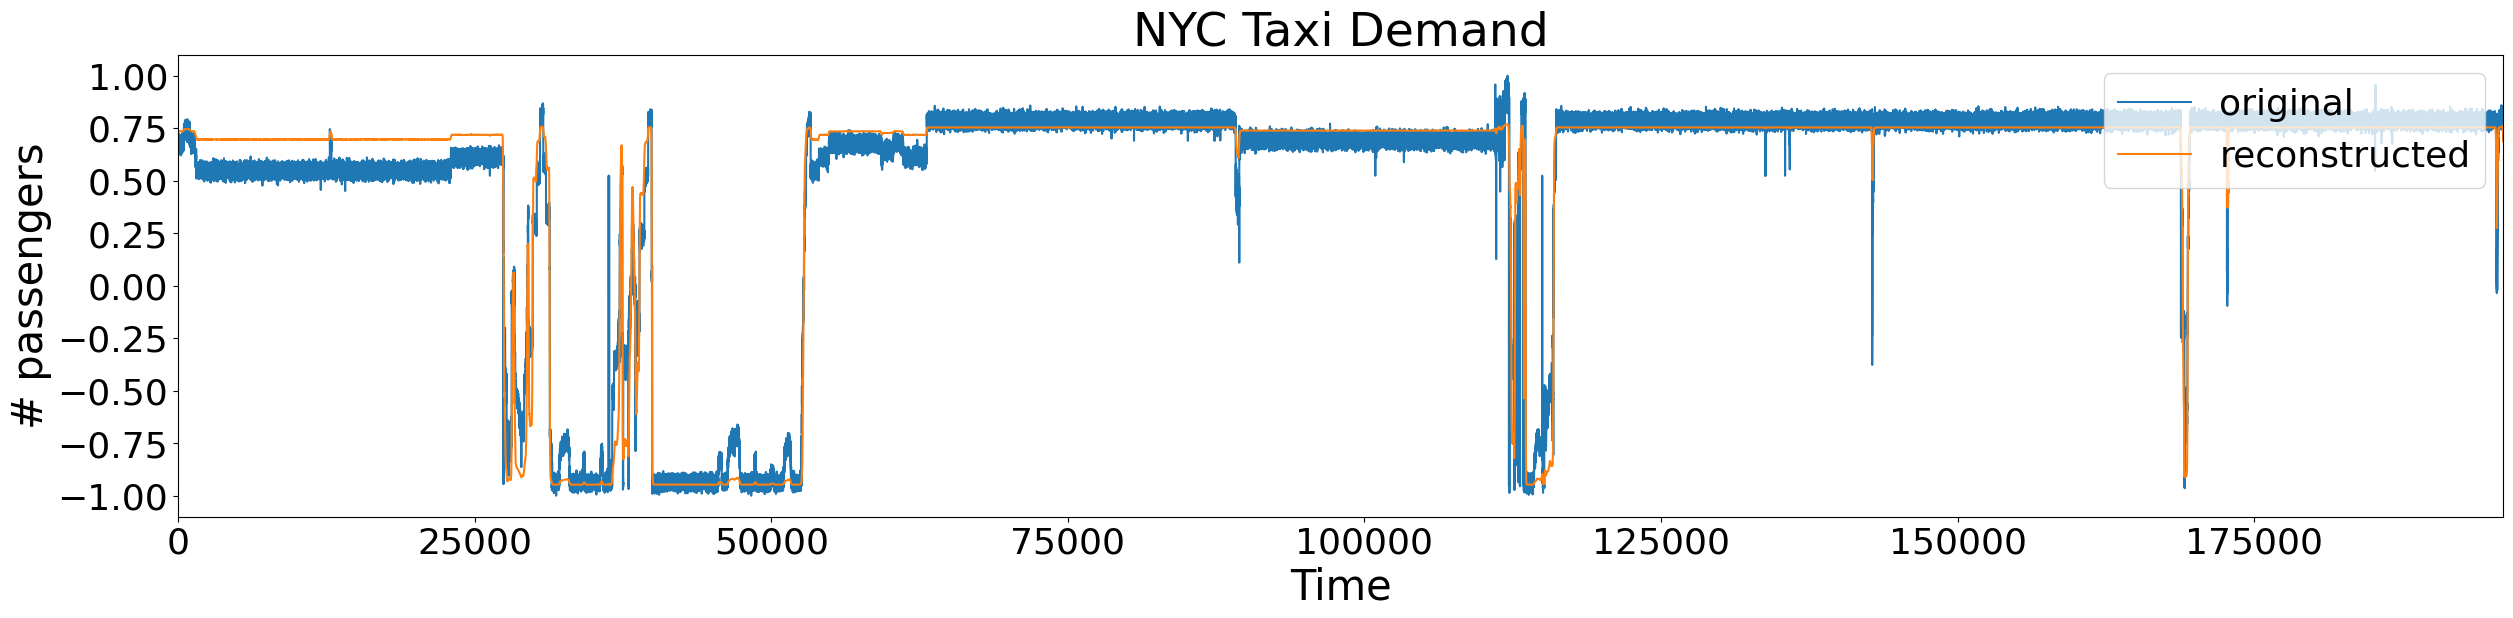

In [16]:
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])


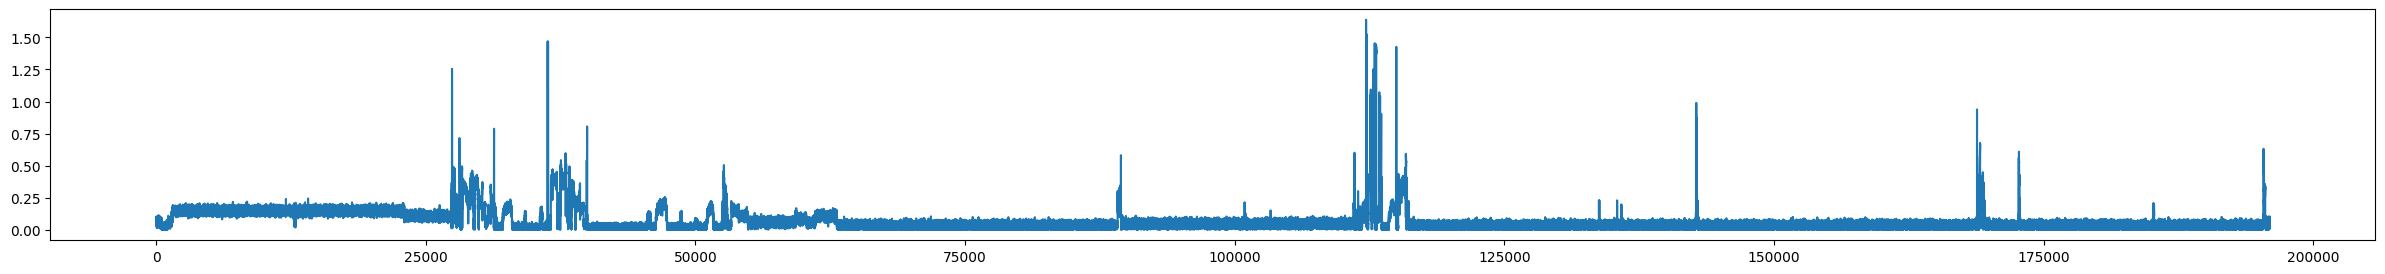

In [17]:
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()


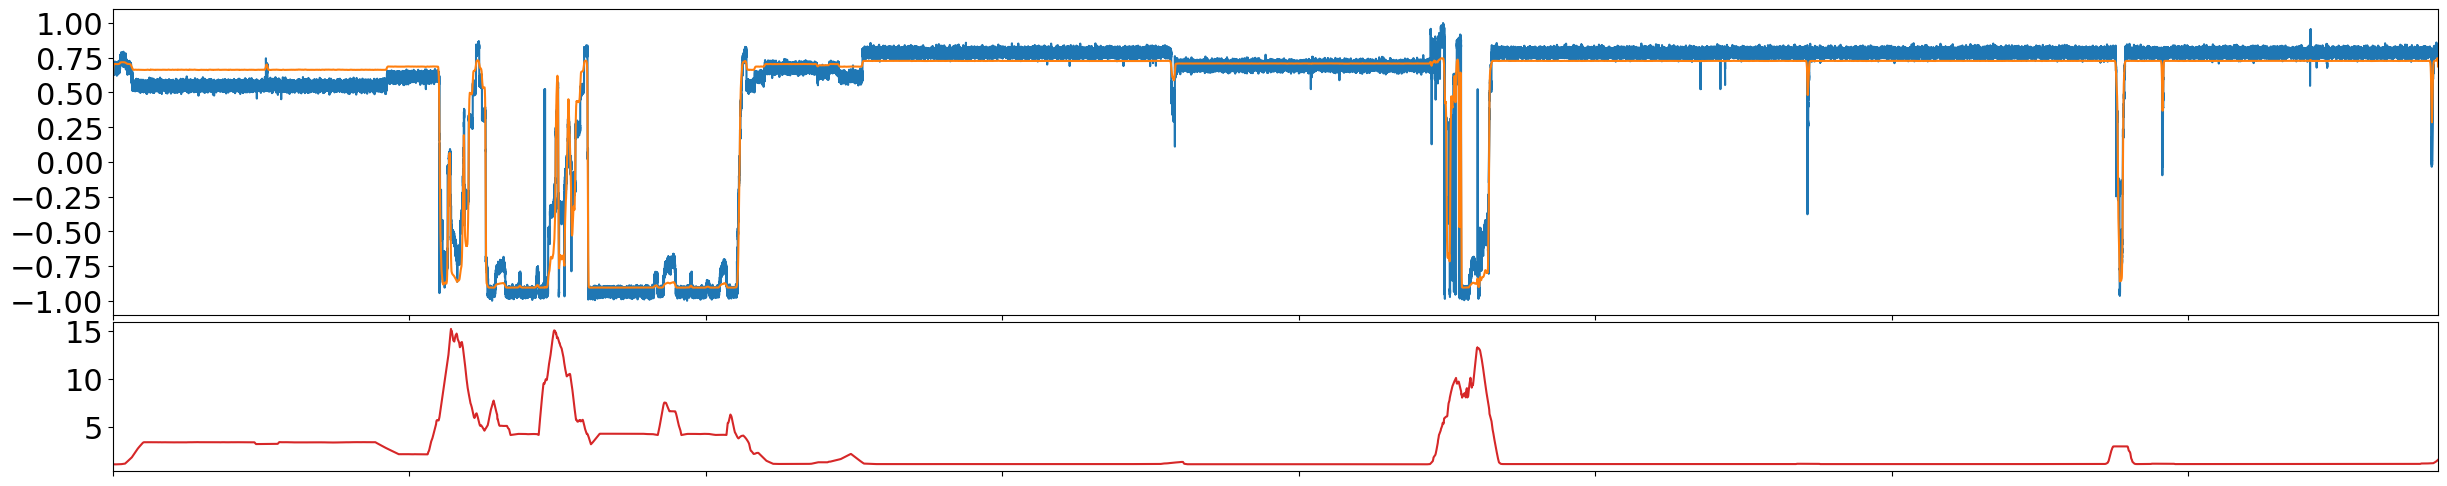

In [18]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold
thresh = 2.8


intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals


[(129180, 1377780, 3.326415427310334),
 (1602780, 3222900, 6.0898431421642245),
 (6698640, 6996960, 8.249022059486293),
 (10116780, 10194900, 2.9287714456760034)]

/home/kazak/hackaton/TADGAN/anomaly-detect/utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


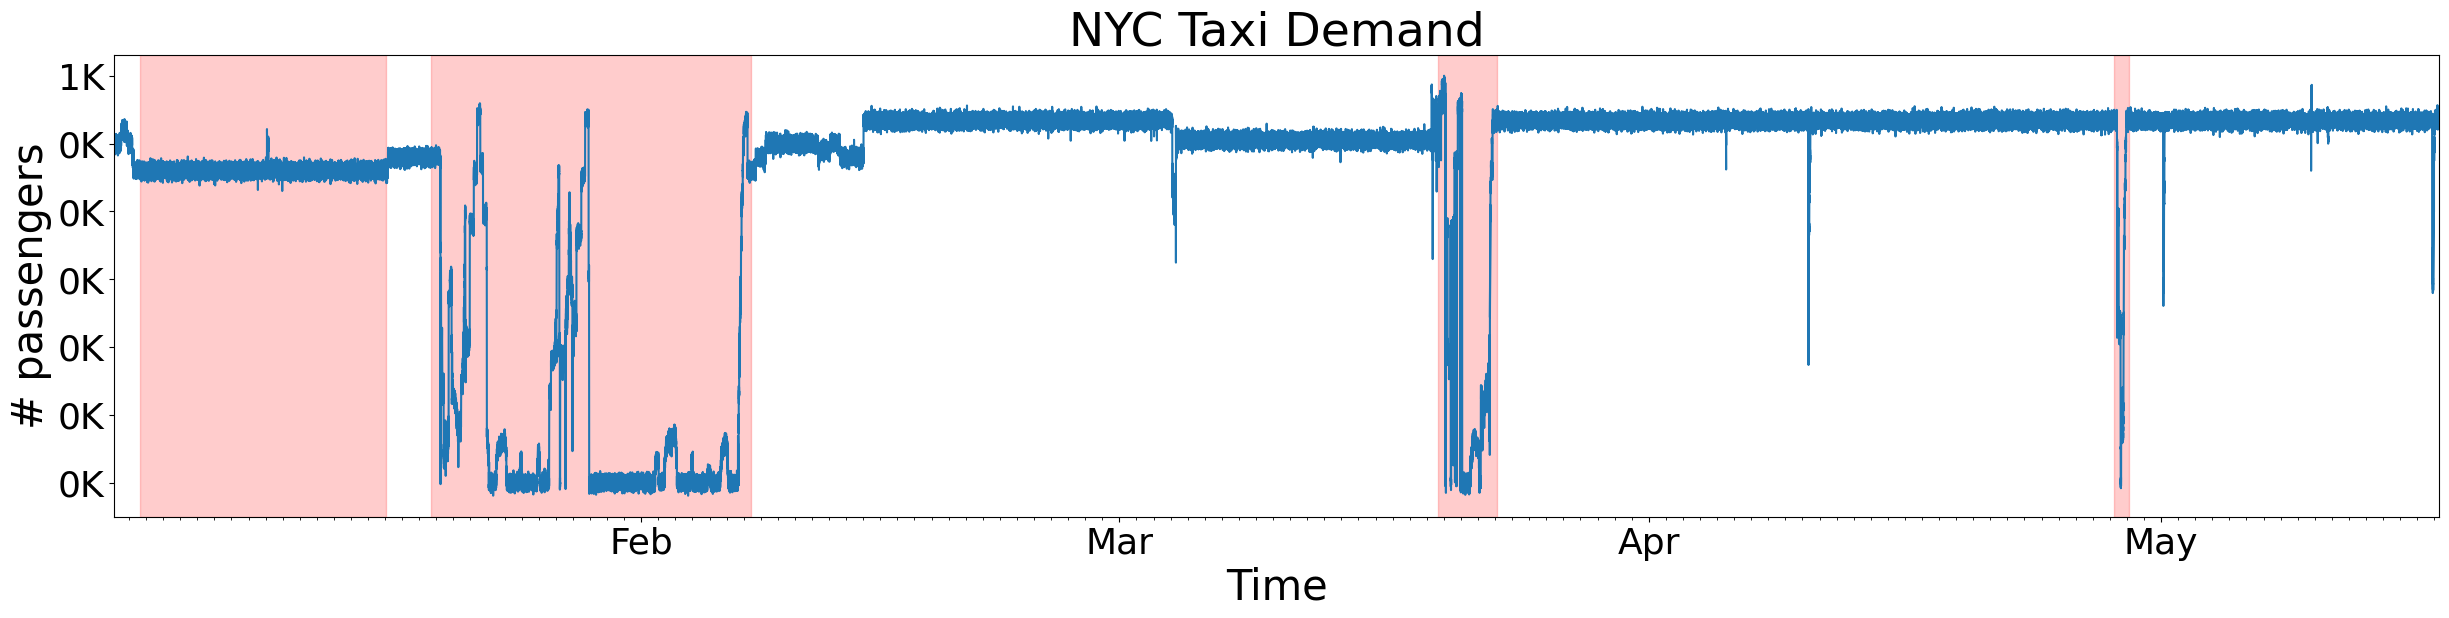

In [28]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
# plot(df, [anomalies, known_anomalies])
plot(df, [anomalies])


In [21]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals


array([[2.21214000e+06, 2.27790000e+06, 4.62788763e-01],
       [2.77728000e+06, 2.81580000e+06, 2.75420644e-01],
       [6.88086000e+06, 6.94362000e+06, 9.11702446e-01],
       [6.98868000e+06, 7.00392000e+06, 9.42112298e-01],
       [1.01052000e+07, 1.02092400e+07, 4.46397318e-01]])

/home/kazak/hackaton/TADGAN/anomaly-detect/utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


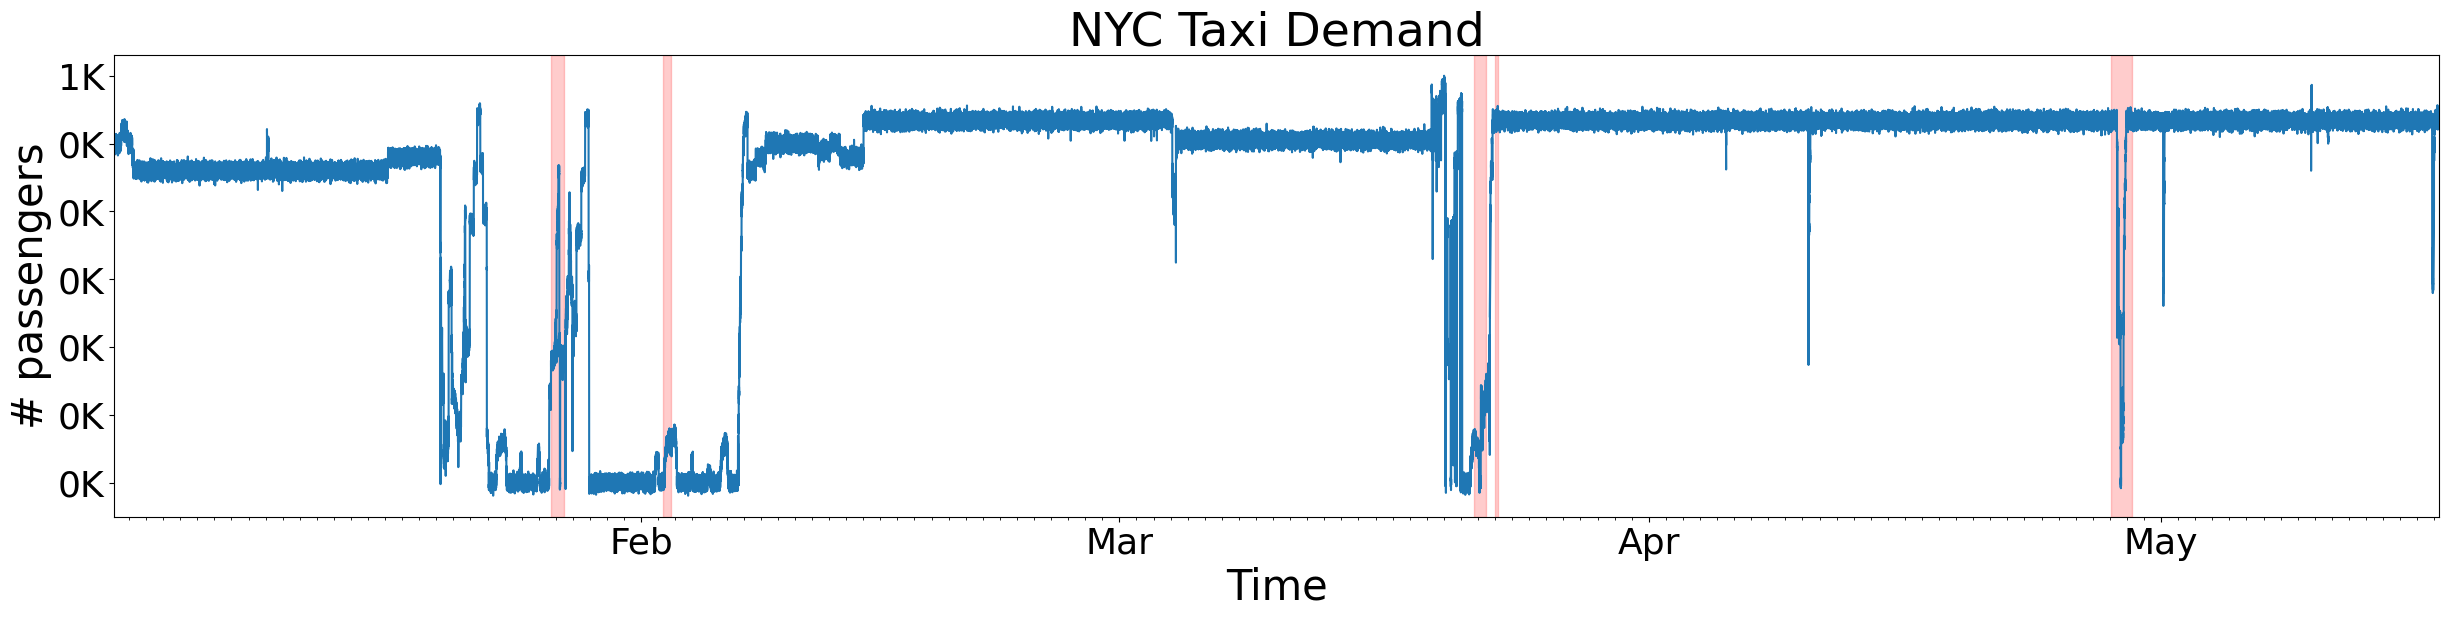

In [22]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
# plot(df, [anomalies, known_anomalies])
plot(df, [anomalies])
